# Setup

In [1]:
import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [2]:
# load baselines: filename!!
with open('CIFAR/results/baselines_freeze_True_pool_True_lr_0.001_nice_curve.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('CIFAR/results/results_freeze_True_reinit_True_pool_True_lr_0.001_nice_curve.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,0.541667,0.178333
1,0.001,0.001,-1,1,0.541667,0.187500
2,0.001,0.001,-1,2,0.625000,0.217333
3,0.001,0.001,-1,3,0.291667,0.186333
4,0.001,0.001,-1,4,0.666667,0.240333


In [3]:
# OR LOAD ARI Scores
with open("FashionMNIST_to_MNIST/results/ari_scores/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,29.196952,15.302891,Finetune,Train
1,0.001,0,0,conv1,33.470783,16.998763,Finetune,Train
2,0.001,0,0,conv2,32.761578,16.035471,Finetune,Train
3,0.001,0,0,conv3,29.000000,15.563708,Finetune,Train
4,0.001,0,0,conv4,31.778795,17.021091,Finetune,Train


# 1. The plots

### Experimental Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

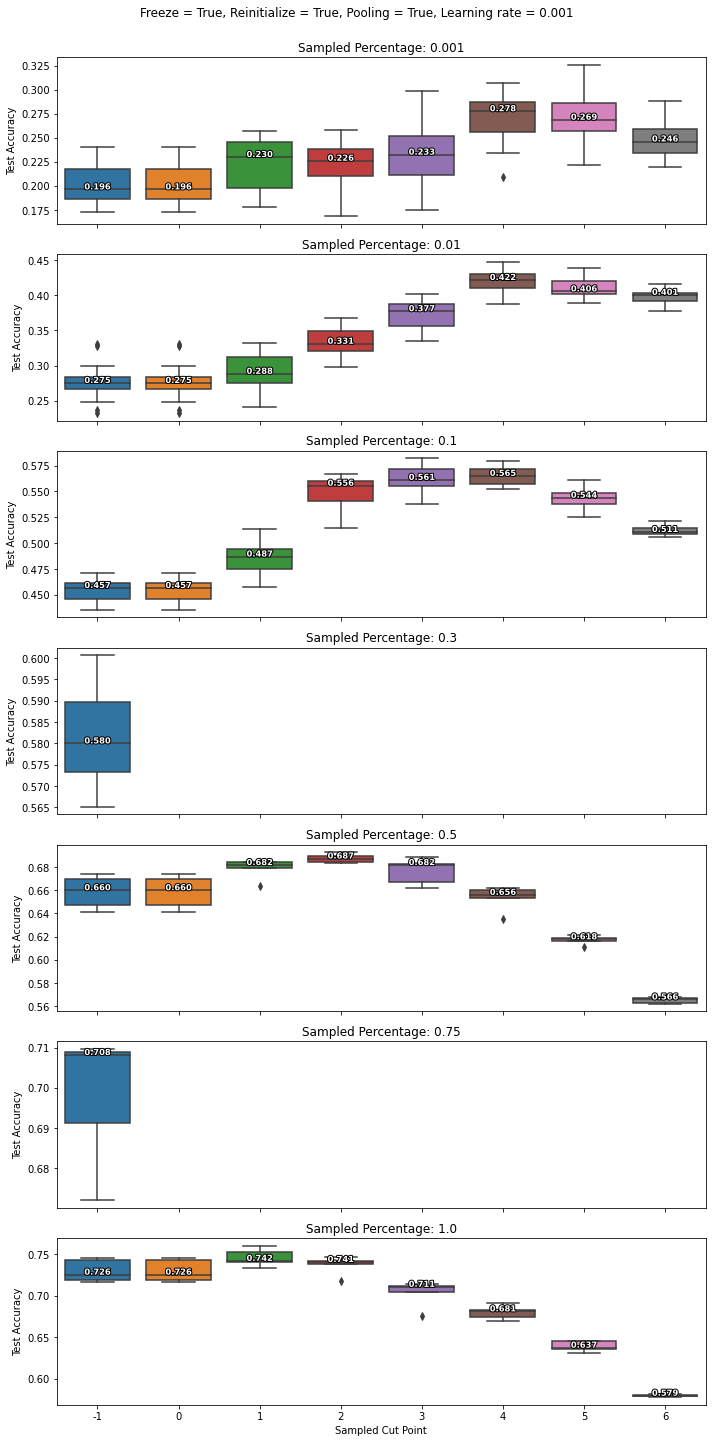

In [4]:
box_plot_percentages_experiments(df, params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

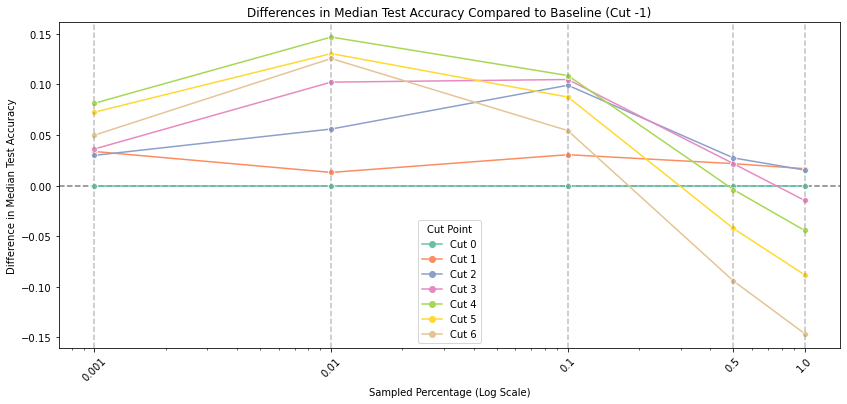

In [5]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

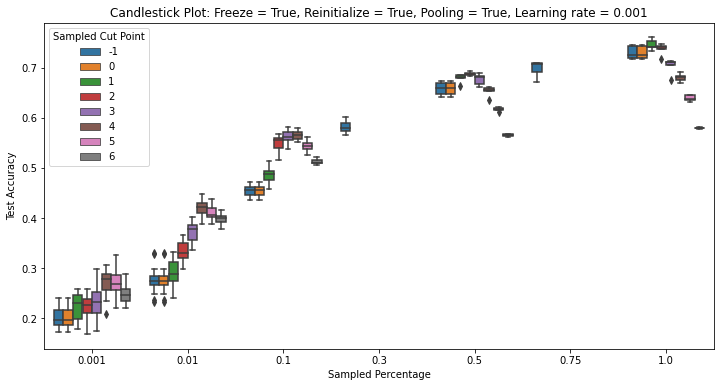

In [6]:
box_plot_full_experiments(df, params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

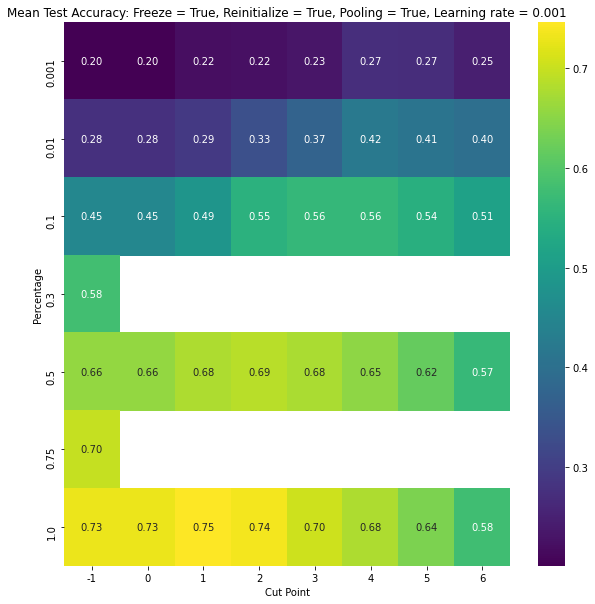

In [7]:
heatmap(df, params, figsize=(10,10))

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

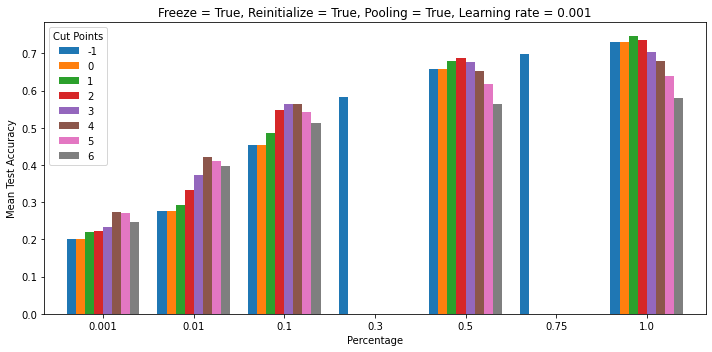

In [10]:
bar_graph(df, params, figsize=(10,5))

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

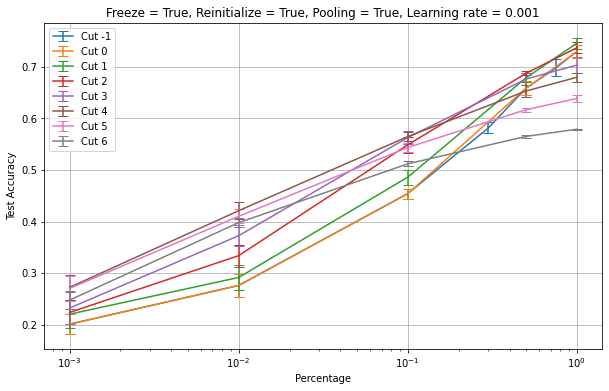

In [13]:
line_plot(df, params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

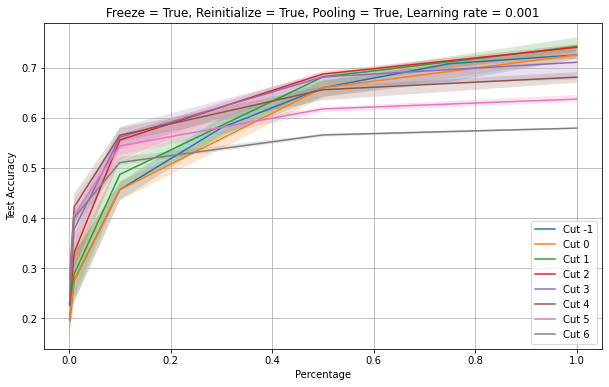

In [14]:
line_pilot_with_ranges(df, params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

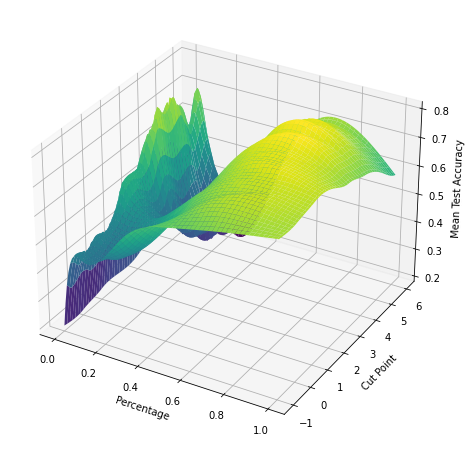

In [15]:
surface_plot(df)

### ARI Box Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

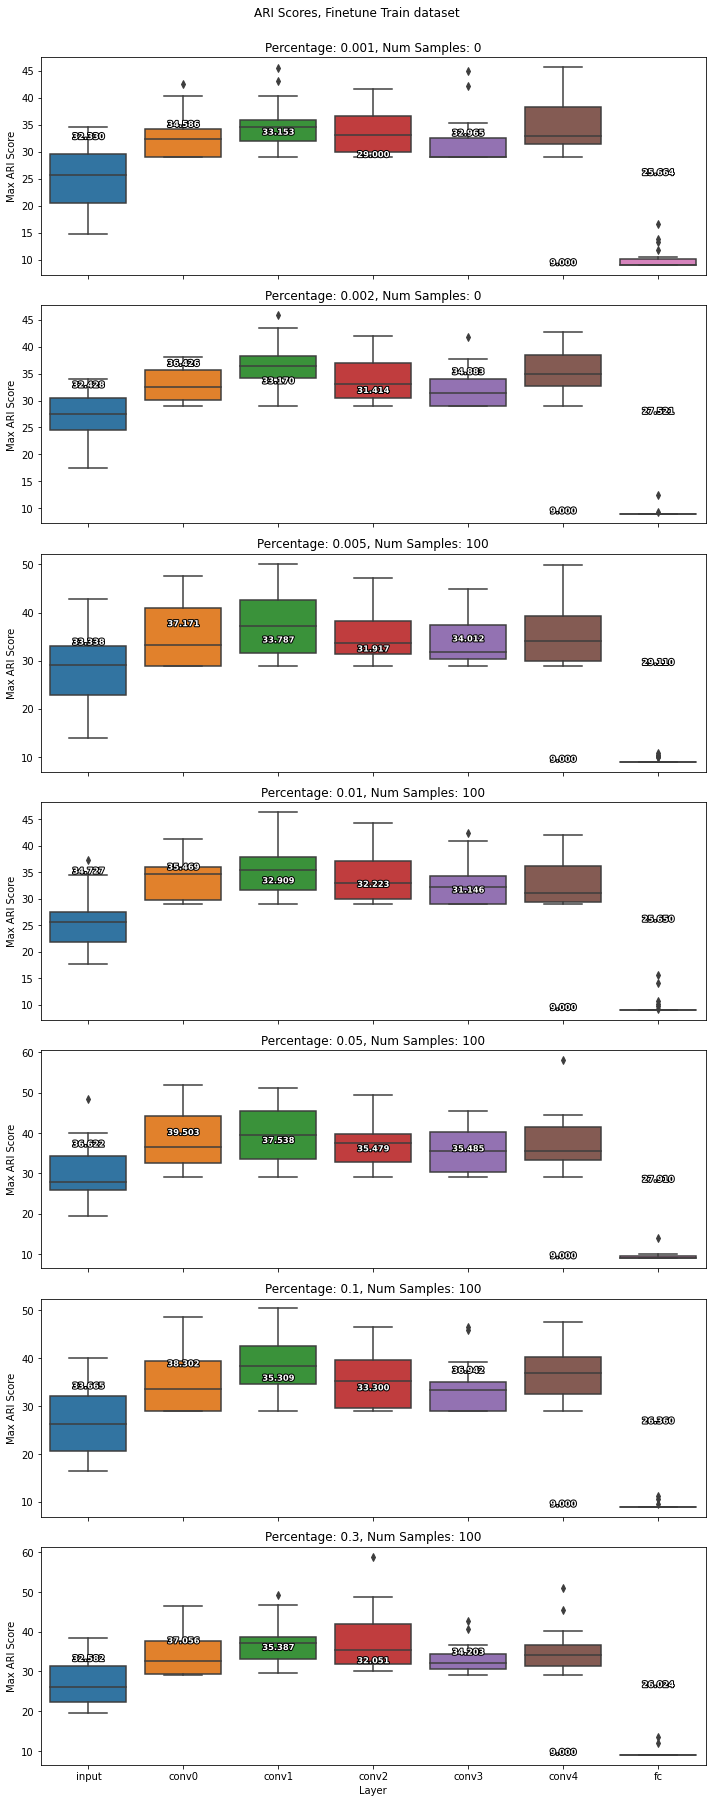

In [16]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores_percentages(df_ari, dataset="Finetune", split="Train", order=layer_names, figsize=(10,25))

# 2. Statistical Tests

### Ranking Cuts

In [17]:
from scipy.stats import wilcoxon

# Assuming df_combined is your original DataFrame
df_differences = df[df['Cut Point'] != -1]

def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['Cut Point'] == cut_point_1]['Test Accuracy']
    data_2 = group[group['Cut Point'] == cut_point_2]['Test Accuracy']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['Percentage'].unique():
    group = df_differences[df_differences['Percentage'] == percentage]
    cut_points = group['Cut Point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'Percentage': percentage,
                'Cut Point 1': cut_points[i],
                'Cut Point 2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [18]:
import pandas as pd

# Assuming df_wilcoxon_pairwise and df_differences are defined as before

# Step 1: Aggregate Test Accuracy and Initialize Rankings
median_accuracy = df_differences.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].median()

rankings = {percentage: {} for percentage in median_accuracy.index.get_level_values(0).unique()}
for (percentage, cut_point), accuracy in median_accuracy.items():
    rankings[percentage][cut_point] = {'median_accuracy': accuracy, 'rank': None, 'group': set([cut_point])}

# Step 2: Group Cuts Based on Statistical Significance
alpha = 0.05  # Significance level

for percentage, cuts_info in rankings.items():
    for cut1, info1 in cuts_info.items():
        for cut2, info2 in cuts_info.items():
            if cut1 != cut2:
                wilcoxon_row = df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['Percentage'] == percentage) & 
                    ((df_wilcoxon_pairwise['Cut Point 1'] == cut1) & (df_wilcoxon_pairwise['Cut Point 2'] == cut2) |
                     (df_wilcoxon_pairwise['Cut Point 1'] == cut2) & (df_wilcoxon_pairwise['Cut Point 2'] == cut1))
                ]
                if not wilcoxon_row.empty and wilcoxon_row.iloc[0]['p_value'] > alpha:
                    # Merge groups if not significantly different
                    info1['group'].update(info2['group'])
                    for cut in info2['group']:
                        info1['group'].update(rankings[percentage][cut]['group'])
                    for cut in info1['group']:
                        rankings[percentage][cut]['group'] = info1['group']

# Step 3: Assign Ranks with Ties
for percentage, cuts_info in rankings.items():
    sorted_groups = sorted({frozenset(info['group']) for cut, info in cuts_info.items()}, key=lambda x: min(median_accuracy[percentage, cut] for cut in x), reverse=True)
    rank = 1
    for group in sorted_groups:
        for cut in group:
            rankings[percentage][cut]['rank'] = rank
        rank += len(group)

# Convert rankings and median accuracies to a DataFrame for easier visualization
df_rankings = pd.DataFrame([(percentage, cut, data['rank'], data['median_accuracy']) for percentage, cuts_info in rankings.items() for cut, data in cuts_info.items()],
                           columns=['Percentage', 'Cut Point', 'rank', 'median_accuracy'])


In [19]:
df_rankings

,Percentage,Cut Point,rank,median_accuracy
0,0.001,0,7,0.196333
1,0.001,1,4,0.230000
2,0.001,2,4,0.226167
3,0.001,3,4,0.232500
4,0.001,4,1,0.277667
5,0.001,5,1,0.268833
6,0.001,6,3,0.246167
7,0.010,0,7,0.275167
8,0.010,1,6,0.288167
9,0.010,2,5,0.331000


# 3. Extras
Don't forget to change the flags to the correct ones for the titles in the params!

In [2]:
from torch import nn
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 5,
      'width': 30, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': str(nn.ReLU),
      'kernel_size': 3,
      # TRAINING PARAMS
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':4096,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 2, 3, 4, 6, 8],
      'fine_tune_classes': [5, 7, 9],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':[0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1],
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

### Extra 1: Split the dictionaries into baseline and fine-tuning one
only run when necessary

In [23]:
with open('results/results_freeze_True_reinit_True_pool_False_truncate_False_3_layers_not_random.json', 'r') as f:
    data_dicts = json.load(f)

params = data_dicts[0]
baselines = [params]
results = [params]
for row in data_dicts[1:]:
    if row["sampled_cut_point"] == -1:
        baselines.append(row)
    else:
        results.append(row)

with open(f'results/baselines_freeze_True_reinit_True_pool_False_truncate_False_3_layers_regular_classes.json', 'w') as f:
    json.dump(baselines, f)
with open(f'results/results_freeze_True_reinit_True_pool_False_truncate_False_3_layers_regular_classes.json', 'w') as f:
    json.dump(results, f)

### Extra 2: Parse Cell outputs
Works only with the standart cell output -see the next cell

In [2]:
# copy the cell output here
out = """
Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9802, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9751, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9755, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9805, Test Accuracy: 0.9577

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9782, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9749, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9716, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9558, Test Accuracy: 0.9520

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9673

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9601, Test Accuracy: 0.9513

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9790, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9790, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9722, Test Accuracy: 0.9593

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9813, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 14
Training Accuracy: 0.9877, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9831, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9840, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9788, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9893, Test Accuracy: 0.9640

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9877, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9557

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9784, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9710, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9700, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9817, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9774, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9772, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9712, Test Accuracy: 0.9587

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9811, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9757, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9730, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 15
Training Accuracy: 0.9922, Test Accuracy: 0.9630

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9685, Test Accuracy: 0.9577

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9903, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9815, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9858, Test Accuracy: 0.9663

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9825, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9813, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9753, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9829, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 5
Training Accuracy: 0.9858, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9657

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 7
Training Accuracy: 0.9920, Test Accuracy: 0.9667

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9657

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 9
Training Accuracy: 0.9879, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9745, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9698, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9698, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9854, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9872, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9778, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9879, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9891, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9683, Test Accuracy: 0.9570

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9819, Test Accuracy: 0.9650

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9833, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9695, Test Accuracy: 0.9587

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9718, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9553, Test Accuracy: 0.9507

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9623, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9837, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9630, Test Accuracy: 0.9530

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9745, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9823, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9819, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 14
Training Accuracy: 0.9877, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 15
Training Accuracy: 0.9922, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9560

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9840, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9885, Test Accuracy: 0.9640

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9755, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9708, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9829, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9656, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9821, Test Accuracy: 0.9630

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9660, Test Accuracy: 0.9527

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9753, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Training Accuracy: 0.9872, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9807, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9593, Test Accuracy: 0.9513

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9741, Test Accuracy: 0.9593

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Training Accuracy: 0.9868, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9821, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Training Accuracy: 0.9825, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9770, Test Accuracy: 0.9550

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9874, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9747, Test Accuracy: 0.9570

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 0
Training Accuracy: 0.9842, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 1
Training Accuracy: 0.9862, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9615, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9786, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9782, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9533

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 6
Training Accuracy: 0.9805, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9716, Test Accuracy: 0.9573

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 9
Training Accuracy: 0.9840, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9718, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9626, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9747, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9846, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9763, Test Accuracy: 0.9527

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9802, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 18
Early stopping invoked.
Training Accuracy: 0.9772, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9796, Test Accuracy: 0.9583
"""

In [3]:
import re

out = re.sub(r'Early stopping invoked.\n', '', out)

results = []
for line in out.split("\n\n"):
    terms = re.sub(r"[:|,|\n]", "\t", line).split("\t")
    terms = [term for term in terms if len(term)>0 and term != ""]
    if len(terms) != 12:
        print(terms)
        print(line)
    else:
        results.append({"lr":0.0001, "sampled_percentage":float(terms[1].strip()), "sampled_cut_point":int(terms[3].strip()), "repeat":int(terms[7].strip()), "train_acc":float(terms[9].strip()), "test_acc":float(terms[11].strip())})

In [7]:
# naming!
import copy
params_tmp = copy.deepcopy(params)
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_0.3.json', 'w') as f:
    json.dump(results, f)

In [8]:
# or append at the end of some other results
# load results; filename
with open('results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model.json', 'r') as f:
    results_old = json.load(f)
results_old.extend(results)

In [11]:
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model_4_cuts.json', 'w') as f:
    json.dump(results_old, f)

### Extra 3: Merge json files

In [3]:
# read all you want to merge (assuming the first element is the params and same for all)

with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_0.001_to_0.01.json', 'r') as f:
    results1 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_0.1_to_0.5.json', 'r') as f:
    results2 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_1.0_to_1.0.json', 'r') as f:
    results3 = json.load(f)

params = results1[0]

results = [params] + results1[1:] + results2[1:] + results3[1:]

# save
with open(f'results_jsons/results_freeze_True_reinit_True_pool_False_random_classes.json', 'w') as f:
    json.dump(results, f)